# Neurosymbolic Software Tutorial (Day 1)

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side as shown. `@TODO`
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, opening this notebook from within Google Drive, and setting WITHIN_GDRIVE to True.



## Outline
```
# Part 1: Data Exploration
- Plot trajectories from `data/example` and explain what a program here should look like.
- End with a pseudo-dsl for this dataset.

# Part 2: DSL Generation
- Explain what a DSL is and how to specify it in this language.
- Show code for generating a DSL from the data.

# Part 3: Program Synthesis
- First, Explain enumeration. Next, show how to call BFS on the DSL and the data.
- Explain NEAR on a high level. Show how to call NEAR on the DSL and the data.

# Feedback
- A google form for comments/questions/concerns on the tutorial and on the framework design.
```

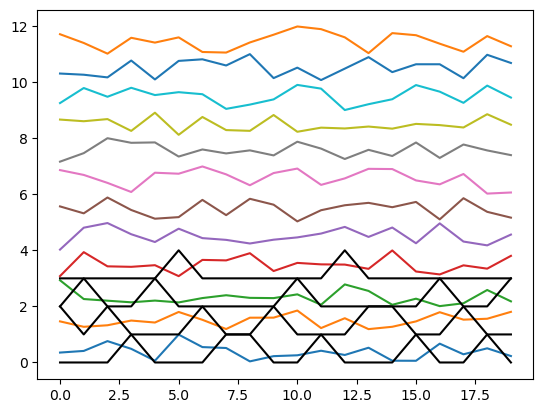